In [ ]:
import torch
import matplotlib.pyplot as plt
from torch import nn,optim
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# device set
def device_setter():
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	print(device)
	return device
device = 'cpu'

In [ ]:
!ls

drive  sample_data


In [ ]:
# step1 = input("Press \n 1: Developer's code(All files present)\n 2:Custom input\n")
neuron_size_list = []
# if step1 == '1':
#   train_data  = np.random.uniform(low=5, high=20, size=(15000,90))
#   train_label = np.random.uniform(low=2, high=5 , size=(15000,1 ))
#   neuron_size_list = [90,50,10]
#   np.savetxt("x.csv", train_data, delimiter=",")
#   np.savetxt("y.csv", train_label, delimiter=",")
# if step1 == '2':
maxtrixX = '/content/drive/MyDrive/MTP_FINAL/Chilikaujainiukai_Inland_Water/x.csv'
maxtrixY = '/content/drive/MyDrive/MTP_FINAL/Chilikaujainiukai_Inland_Water/y.csv'
no_of_nerons = 3
neuron_size_list = [401, 50, 10]
train_data = pd.read_csv(maxtrixX, sep=',',header=None).to_numpy()
train_label = pd.read_csv(maxtrixY,sep=',',header=None).to_numpy()
print("Features dimensions \t: ",train_data.shape)
print("Label dimensions \t: ",train_label.shape)
print("neuron_size_list \t: ",neuron_size_list)

Features dimensions 	:  (38, 401)
Label dimensions 	:  (38, 1)
neuron_size_list 	:  [401, 50, 10]


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
sc = StandardScaler()
 
train_data = sc.fit_transform(train_data)


pca = PCA(n_components = 2)
train_data = pca.fit_transform(train_data)
 
explained_variance = pca.explained_variance_ratio_


In [ ]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.1, random_state=60)

In [ ]:
explained_variance

array([0.87730646, 0.10156459])

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, features, labels):
        super(NeuralNet,self).__init__()
        self.features = torch.tensor(features, device=device)
        self.labels = torch.tensor(labels, device = device)
        self.input_size = int(self.features.shape[1])
        self.output_size = 1
        self.hidden_sizes = neuron_size_list
        self.train_samples = features.shape[0]
        self.output = None
        self.criterion = None
        self.optimizer = None
        self.hidden_size = neuron_size_list
        self.hidden = []
        for i in range(len(neuron_size_list)):
        	self.hidden.append(None)
        self.activation = None

    def forward(self, features):
        x = features.type(torch.float)
        for j in range(len(neuron_size_list)):
          x = self.activation(self.hidden[j](x))
        x = self.output(x)
        return x
    

    def build_nn(self):
        for j in range(len(neuron_size_list)):
          if j == 0:
            self.hidden[j] = nn.Linear(self.input_size,self.hidden_size[j])  
          else:
        	  self.hidden[j] = nn.Linear(self.hidden_size[j-1],self.hidden_size[j])
        self.hidden = torch.nn.ModuleList(self.hidden)
        self.output = nn.Linear(self.hidden_size[-1], self.output_size)
        self.activation = nn.LeakyReLU(0.01)

    def train_nn(self,test_features,y_test,norm = 1):
        # write the training loop here; you can use either tensorflow or pytorch
        # print validation accuracy
        loss_list = []
        batch_size = 256
        #self.criterion = nn.CrossEntropyLoss()
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.0001) # 0.0001
        for epoch in range(5000): 
          is_print = True
          for row_num in range(0, self.train_samples, batch_size):
            last_index = min(row_num + batch_size, self.train_samples)
            x_train = self.features[row_num:last_index,:]
            y_train = self.labels[row_num:last_index].squeeze()
            y_pred = self.forward(x_train).squeeze()
            self.optimizer.zero_grad()
            train_loss = self.criterion(y_pred, y_train) 
            train_loss.backward()
            nn.utils.clip_grad_norm_(self.parameters(), norm)
            self.optimizer.step() 
          with torch.no_grad():
            y_pred = self.forward(self.features).squeeze()
            loss = self.criterion(y_pred, self.labels)
            if epoch%10==0:
              print(f"epoch: {epoch} loss :{loss.item()}")
            loss_list.append(loss.item())
        return loss_list
        

    def predict(self, test):
        # return a list containing all the ratings predicted by the trained model
        x = test.type(torch.float)
        for j in range(len(neuron_size_list)):
          x = self.activation(self.hidden[j](x))
        x = self.output(x)
        return x

## **Using L1 norm**

In [ ]:
model=NeuralNet(X_train,y_train.astype('float32'))
model.build_nn()
model.to(device)
losses_l1 = model.train_nn(X_train,y_train,1)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([34, 1])) that is different to the input size (torch.Size([34])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0 loss :390.7320861816406
epoch: 10 loss :366.10931396484375
epoch: 20 loss :339.7649841308594
epoch: 30 loss :309.6396484375
epoch: 40 loss :280.5888366699219
epoch: 50 loss :253.6697998046875
epoch: 60 loss :230.49859619140625
epoch: 70 loss :211.31793212890625
epoch: 80 loss :195.5307159423828
epoch: 90 loss :182.30516052246094
epoch: 100 loss :170.25445556640625
epoch: 110 loss :156.76263427734375
epoch: 120 loss :144.4686737060547
epoch: 130 loss :134.63583374023438
epoch: 140 loss :127.22830963134766
epoch: 150 loss :122.13497161865234
epoch: 160 loss :122.10916137695312
epoch: 170 loss :128.63137817382812
epoch: 180 loss :138.34828186035156
epoch: 190 loss :133.99183654785156
epoch: 200 loss :132.12545776367188
epoch: 210 loss :130.79977416992188
epoch: 220 loss :129.65647888183594
epoch: 230 loss :128.69480895996094
epoch: 240 loss :128.1407012939453
epoch: 250 loss :127.30915069580078
epoch: 260 loss :126.65889739990234
epoch: 270 loss :126.09622192382812
epoch: 280 los

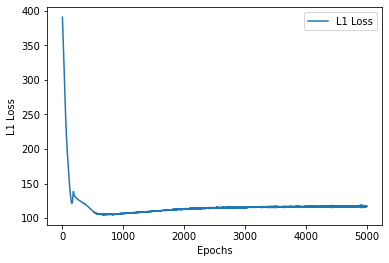

In [ ]:
plt.plot(losses_l1,label='L1 Loss')
plt.ylabel('L1 Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
predy = model.predict(torch.from_numpy(X_test))

In [ ]:
# type(predy), type(train_label)
def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2
print(f"R square :{r2_loss(predy, torch.from_numpy(y_test)).item()}")

R square :0.7131305611363412


In [ ]:
print("Global Minima :",np.amin(losses_l1))

Global Minima : 104.64218139648438


**Verification of GLobal Minima**

104.64218139648438


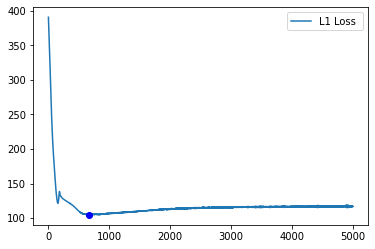

In [ ]:
a = np.round(np.array(losses_l1),2)
print(np.amin(losses_l1))
plt.plot(a,label='L1 Loss ')
minima_ind = losses_l1.index(np.amin(losses_l1))
plt.plot(minima_ind ,a[minima_ind],'bo')
plt.legend()
plt.ion() # This should make the graph interactive
plt.show()

$\therefore$ every local minimum point of the loss function L(W) is a global minimum point

**Saddle points**

In [ ]:
prev = a[0] 
saddle_pts = []
saddle_ind = []
for pt in range(len(losses_l1)-1):
  if prev >= a[pt] and a[pt] <= a[pt+1] and a[pt] != a[minima_ind]:
    saddle_ind.append(pt)
    saddle_pts.append(a[pt]) 
print("Some saddle points",random.choices(saddle_pts,k=3))

Some saddle points [107.98, 112.34, 116.23]


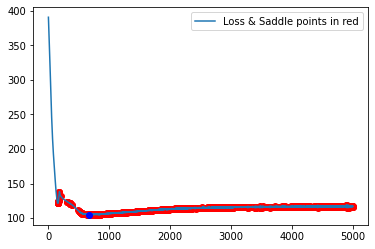

In [ ]:
plt.plot(saddle_ind ,saddle_pts,'ro')
plt.plot(a,label='Loss & Saddle points in red')
plt.plot(minima_ind ,a[minima_ind],'bo')
plt.legend()
plt.ion() 
plt.show()

$\therefore$ every stationary point of the loss function L(W) which is not a global minimum point is a saddle
point

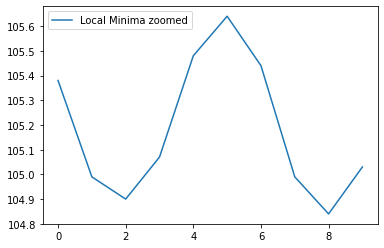

In [ ]:
plt.plot(a[10+minima_ind: minima_ind +20],label='Local Minima zoomed')
plt.legend()
plt.show()

## **Using Frobenius norm**

In [ ]:
model=NeuralNet(train_data,train_label.astype('float32'))
model.build_nn()
model.to(device)
losses_l2 = model.train_nn(train_data,train_label,2)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([38, 1])) that is different to the input size (torch.Size([38])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0 loss :390.101806640625
epoch: 10 loss :373.9383239746094
epoch: 20 loss :351.8277893066406
epoch: 30 loss :323.88909912109375
epoch: 40 loss :293.73114013671875
epoch: 50 loss :264.93878173828125
epoch: 60 loss :238.71383666992188
epoch: 70 loss :214.6533966064453
epoch: 80 loss :193.43983459472656
epoch: 90 loss :175.39224243164062
epoch: 100 loss :159.8218231201172
epoch: 110 loss :147.09625244140625
epoch: 120 loss :137.27587890625
epoch: 130 loss :130.1778106689453
epoch: 140 loss :125.82473754882812
epoch: 150 loss :124.53773498535156
epoch: 160 loss :126.61507415771484
epoch: 170 loss :131.806884765625
epoch: 180 loss :134.17108154296875
epoch: 190 loss :130.0357208251953
epoch: 200 loss :129.45407104492188
epoch: 210 loss :129.1337890625
epoch: 220 loss :127.5759506225586
epoch: 230 loss :127.10044860839844
epoch: 240 loss :126.16437530517578
epoch: 250 loss :125.40839385986328
epoch: 260 loss :124.95169830322266
epoch: 270 loss :124.37396240234375
epoch: 280 loss :123.

In [ ]:
predy = model.predict(torch.from_numpy(X_test))

**Global Minima**

In [ ]:
print("Global Minima :",np.amin(losses_l2))

Global Minima : 109.20787811279297


**Plot of Loss**

109.20787811279297


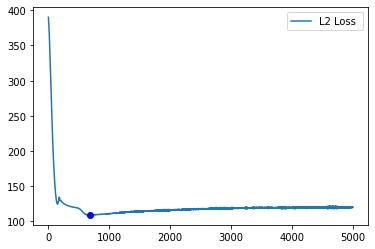

In [ ]:
a = np.round(np.array(losses_l2),2)
print(np.amin(losses_l2))
plt.plot(a,label='L2 Loss ')
minima_ind = losses_l2.index(np.amin(losses_l2))
plt.plot(minima_ind ,a[minima_ind],'bo')
plt.legend()
plt.ion() 
plt.show()

$\therefore$ every local minimum point of the loss function L(W) is a global minimum point

In [ ]:
print(f"R square :{r2_loss(predy, torch.from_numpy(y_test)).item()}")

R square :0.8908723943838055


**Saddle points**

In [ ]:
prev = a[0] 
saddle_pts = []
saddle_ind = []
for pt in range(len(losses_l2)-1):
  if prev >= a[pt] and a[pt] <= a[pt+1] and a[pt] != a[minima_ind]:
    saddle_ind.append(pt)
    saddle_pts.append(a[pt])
print("Some saddle points",random.choices(saddle_pts,k=3))

Some saddle points [109.78, 119.17, 113.83]


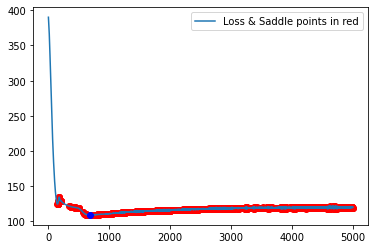

In [ ]:
plt.plot(saddle_ind ,saddle_pts,'ro')
plt.plot(a,label='Loss & Saddle points in red')
plt.plot(minima_ind ,a[minima_ind],'bo')
plt.legend()
plt.ion()
plt.show(block=True)

$\therefore$ every stationary point of the loss function L(W) which is not a global minimum point is a saddle
point

**Part 3**

In [ ]:
ranks = []
for i in range(len(neuron_size_list)):
  model.hidden[0].weight.shape
  m = model.hidden[0].weight.cpu()
  rank = np.linalg.matrix_rank(m.detach().numpy())
  ranks.append(rank)
  print(f"Rank for hidden{i} matrix is {rank}")
r = ranks[0]
if (ranks == ranks[0]).all() == True:
  print(f"p = {r}")

Rank for hidden0 matrix is 2
Rank for hidden1 matrix is 2
Rank for hidden2 matrix is 2
p = 2


In [ ]:
def hessian(x):
    x_grad = np.gradient(x) 
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype=x.dtype) 
    for k, grad_k in enumerate(x_grad):
        tmp_grad = np.gradient(grad_k) 
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
    return hessian

In [ ]:
hessian(np.array(saddle_pts))

array([[[ 3.26158582e-316,  7.00000000e-002,  1.05000000e-001, ...,
         -2.25000000e-001,  6.29570889e+078,  5.17961155e+184]]])

**Perturbed Gradient Descent**

In [ ]:
def perturbed_GD_vanilla(x, eta, r, K): 
  kp = 0
  for k in range(10):
    if k - kp > K :
      x = np.subtract(x,eta * float(2*r))
    grad = np.array(np.gradient(x)) * eta
    x = x - grad
  return x
x_new = perturbed_GD_vanilla(train_data, 1e-3, 0.25,0.5)
x_new

The above algorithm is crashing. So trying other variants

In [ ]:
def perturbed_GD_m1(x, eta, r, K): # slight modification(m1)
  kp = 0
  for k in range(10):
    if k - kp > K :
      delta = list(map(lambda p : p + np.random.uniform(r), np.gradient(x)))
      # np.abs(np.random.normal(r)) can also be used
      delta_n = np.array(delta)
      x = x - eta * delta_n
  return x
x_new = perturbed_GD_m1(train_data, 1e-1, 0.25, 0.5)
x_new

Session still crashed for m1

In [ ]:
def compute_steplength(x, alpha , tol, r):
  cur_grad = np.linalg.norm(x -  np.gradient(alpha * x))
  prev_grad = cur_grad
  counter = 0
  while( cur_grad > tol and counter <= 3):
    alpha = alpha / np.random.uniform(r) # np.random.uniform(r) - Pertubation
    print("alpha :",alpha)
    cur_grad = np.linalg.norm(x -  np.gradient(alpha * x))
    if prev_grad == cur_grad:
      counter+=1
    else:
      prev_grad = cur_grad
    print("- ",cur_grad)
  return alpha

def perturbed_GD_m2(x, eta, r, K): 
  kp = 0
  k = 0
  grad = np.gradient(train_data)
  while(np.linalg.norm(grad) > eta):
    if k - kp > K :
      eta = compute_steplength(x, eta , 1e-1, r)
    k += 1
    grad = np.array(np.gradient(x))
    x = x - grad * eta
  return x
x_new = perturbed_GD_m2(train_data, 1e-1, 5,0.5)
x_new

Even after making modifications to the perturbed Gradient Descent(m2) the application is still crashing